In [1]:
from tune_sklearn import TuneSearchCV
from xgboost import XGBClassifier
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter

In [2]:
x_train = np.load("trainX_ct.npy")
y_train = np.load("trainY_ct.npy")
x_test = np.load("testX_ct.npy")
y_test = np.load("testY_ct.npy")

### Tuning parameters

In [3]:
parameter_grid = {
    "min_child_weight": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    "gamma": (0.5, 5),
    "subsample": (0.6, 1.0),
    "colsample_bytree": (0.6, 1.0),
    "max_depth": [3, 4, 5],
}

xgb = XGBClassifier(
    learning_rate=0.02,
    n_estimators=50,
    objective="binary:logistic",
    nthread=10,
    tree_method="gpu_hist",
    use_label_encoder=False,
    eval_metric="mlogloss"
)

x_train_tune, x_test_tune, y_train_tune, y_test_tune = train_test_split(x_train, y_train, test_size=.2, random_state=29)

In [4]:
tune_search = TuneSearchCV(
    xgb,
    parameter_grid,
    use_gpu=True,
    search_optimization="bayesian",
    n_trials=10,
    early_stopping=False,
    max_iters=1,
    local_dir='.',
    return_train_score=True,
    verbose=1
)
tune_search.fit(x_train_tune, y_train_tune)

TuneSearchCV(early_stopping=False,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     eval_metric='mlogloss', gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.02, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_c...
                      <class 'ray.tune.logger.CSVLogger'>],
             n_jobs=-1,
             param_distributions={'colsample_bytree': (0.6, 1.0),
                                  'gamma': (0.5, 5), 'max_depth': [3, 4, 5],
                                  'min_child_weight': [1,

In [5]:
print(tune_search.best_params_)

{'min_child_weight': 5, 'gamma': 2.751023491643122, 'subsample': 0.9274103084667017, 'colsample_bytree': 0.7976354392235654, 'max_depth': 5}


In [6]:
# best classifier
xgb = XGBClassifier(
    learning_rate=0.02,
    n_estimators=50,
    objective="binary:logistic",
    nthread=10,
    tree_method="gpu_hist",
    use_label_encoder=False,
    eval_metric="mlogloss",
    **tune_search.best_params_)
xgb.fit(x_train_tune, y_train_tune)
xgb.score(x_test_tune, y_test_tune)

0.720558882235529

### Training local models

In [7]:
def tuning(learners, local_ds, theta):
    global_predictions = []
    for learner in learners:
        global_predictions.append(learner.predict(global_set_x))
    global_predictions = np.array(global_predictions)
    
    certain_global_x = []
    certain_global_predictions = []
    correct_count = 0
    for i in range(len(global_set_x)):
        tmp = np.zeros(n_classes)
        for pred in global_predictions[:, i]:
            tmp[pred] += 1
        if tmp.max() >= theta:
            certain_global_x.append(global_set_x[i])
            certain_global_predictions.append(np.argmax(tmp))
            if np.argmax(tmp) == global_set_y[i]:
                correct_count += 1
    print("Certain predictions amount", len(certain_global_predictions), "with correct in them", correct_count)
    
    learners = []
    acc = 0
    for i in range(n_learners):
        xgb = XGBClassifier(
            learning_rate=0.02,
            n_estimators=50,
            objective="binary:logistic",
            nthread=10,
            tree_method="gpu_hist",
            use_label_encoder=False,
            eval_metric="mlogloss",
            **tune_search.best_params_)
        if len(certain_global_x) > 0:
            local_X = np.vstack([local_set_x[i*local_ds:(i+1)*local_ds], certain_global_x])
            local_Y = np.hstack([local_set_y[i*local_ds:(i+1)*local_ds], certain_global_predictions])
        else:
            local_X = local_set_x[i*local_ds:(i+1)*local_ds]
            local_Y = local_set_y[i*local_ds:(i+1)*local_ds]
        xgb.fit(local_X, local_Y)
        acc += xgb.score(x_test, y_test)
        learners.append(xgb)
    #print("Average accuracy of local workers", acc/n_learners)
        
    return learners, acc/len(learners)

In [8]:
n_classes = len(np.unique(y_train))
# unlabeled examples
m = 30000
global_set_x = x_train[:m]
global_set_y = y_train[:m]
# labeled examples
local_set_x = x_train[m:]
local_set_y = y_train[m:]
n = len(x_train) - m
n_learners = 5
theta = 5
local_ds = n//n_learners
print("Length of the local dataset", local_ds)

Length of the local dataset 3518


In [9]:
learners = []
acc = 0
for i in range(n_learners):
    xgb = XGBClassifier(
        learning_rate=0.02,
        n_estimators=50,
        objective="binary:logistic",
        nthread=10,
        tree_method="gpu_hist",
        use_label_encoder=False,
        eval_metric="mlogloss",
        **tune_search.best_params_)
    local_X = local_set_x[i*local_ds:(i+1)*local_ds]
    local_Y = local_set_y[i*local_ds:(i+1)*local_ds]
    #print(Counter(local_Y))
    xgb.fit(local_X, local_Y)
    acc += xgb.score(x_test, y_test)
    learners.append(xgb)
print("Average accuracy of local workers", acc/n_learners)

Average accuracy of local workers 0.7102445583662492


In [10]:
for i in range(10):
    learners, acc = tuning(learners, local_ds, theta)
    print(acc)

Certain predictions amount 21592 with correct in them 17208
0.6912009412555677
Certain predictions amount 28610 with correct in them 19894
0.6836540885788722
Certain predictions amount 29383 with correct in them 19965
0.678275485334902
Certain predictions amount 29576 with correct in them 19916
0.6756534162534666
Certain predictions amount 29606 with correct in them 19870
0.6748466257668712
Certain predictions amount 29629 with correct in them 19869
0.6745440793343979
Certain predictions amount 29607 with correct in them 19846
0.6731994285234053
Certain predictions amount 29654 with correct in them 19839
0.6730649634423062
Certain predictions amount 29652 with correct in them 19832
0.6726951844692831
Certain predictions amount 29639 with correct in them 19814
0.6728464576855199


In [96]:
local_ds_options = [150, 200, 250, 300, 400, 500, 600, 700, 800]
theta = 11
accuracies = []
for local_ds in local_ds_options:
    print("Local dataset size", local_ds)
    accuracies.append([])
    learners = []
    acc = 0
    for i in range(n_learners):
        xgb = XGBClassifier(
            learning_rate=0.02,
            n_estimators=50,
            objective="binary:logistic",
            nthread=10,
            tree_method="gpu_hist",
            use_label_encoder=False,
            eval_metric="mlogloss",
            **tune_search.best_params_)
        local_X = local_set_x[i*local_ds:(i+1)*local_ds]
        local_Y = local_set_y[i*local_ds:(i+1)*local_ds]
        xgb.fit(local_X, local_Y)
        acc += xgb.score(x_test, y_test)
        learners.append(xgb)
    accuracies[-1].append(acc/len(learners))
    for i in range(5):
        learners, acc = tuning(learners, local_ds, theta)
        accuracies[-1].append(acc)

Local dataset size 150
Local dataset size 200
Local dataset size 250
Local dataset size 300
Local dataset size 400
Local dataset size 500
Local dataset size 600
Local dataset size 700
Local dataset size 800


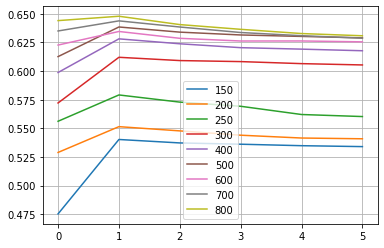

In [97]:
import matplotlib.pyplot as plt
%matplotlib inline

for ind, ld in enumerate(local_ds_options):
    accs = accuracies[ind]
    plt.plot(range(len(accs)), accs, label=str(ld))
plt.grid()
plt.legend()
plt.show()

In [98]:
local_ds = 300
theta_options = [8,9,10,11,12,13,14]
accuracies = []
for theta in theta_options:
    print("Theta", theta)
    accuracies.append([])
    learners = []
    acc = 0
    for i in range(n_learners):
        xgb = XGBClassifier(
            learning_rate=0.02,
            n_estimators=50,
            objective="binary:logistic",
            nthread=10,
            tree_method="gpu_hist",
            use_label_encoder=False,
            eval_metric="mlogloss",
            **tune_search.best_params_)
        local_X = local_set_x[i*local_ds:(i+1)*local_ds]
        local_Y = local_set_y[i*local_ds:(i+1)*local_ds]
        xgb.fit(local_X, local_Y)
        acc += xgb.score(x_test, y_test)
        learners.append(xgb)
    accuracies[-1].append(acc/len(learners))
    for i in range(5):
        learners, acc = tuning(learners, local_ds, theta)
        accuracies[-1].append(acc)

Theta 8
Theta 9
Theta 10
Theta 11
Theta 12
Theta 13
Theta 14


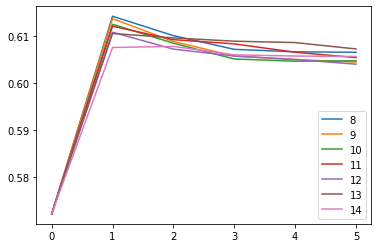

In [99]:
for ind, th in enumerate(theta_options):
    accs = accuracies[ind]
    plt.plot(range(len(accs)), accs, label=str(th))
plt.legend()
plt.show()